In [2]:
##### Load packages #####
library(tidyverse)
library(multcomp)
library(ggplot2)
library(car)
library(MASS)
library(stats)
library(sjPlot)
library(tidyverse)
library(lme4)
library(lmerTest)
library(LMERConvenienceFunctions)
library(multcomp)

In [3]:
# Load CSV
dir_name <- basename(getwd())
csv_file <- paste0(dir_name, ".csv")
graphdata <- read.csv(csv_file)

Trial_list <- c("Trial01", "Trial02", "Trial03", "Trial04", "Trial05", "Trial06", "Trial07", "Trial08", "Trial09", "Trial10")

#add column index
colnames(graphdata) <- paste0(sprintf("%02d", seq_along(colnames(graphdata))), " ", colnames(graphdata))

# Identify rows with NA (used to detect the gaps) in graphdata
gap_rows <- which(rowSums(is.na(graphdata)) == ncol(graphdata))

# Assign groups dynamically using Trial_list
graphdata$Group <- NA  # Initialize Group column

# Create a sequence of rows to handle gaps
gap_rows <- c(0, gap_rows, nrow(graphdata) + 1)  # Include start and end boundaries
current_trial_index <- 1  # Start from the first trial in Trial_list

# Assign groups dynamically
for (i in seq_along(gap_rows[-1])) {
  start <- gap_rows[i] + 1  # Start of the current block
  end <- gap_rows[i + 1] - 1  # End of the current block
  
  if (start <= end) {
    graphdata$Group[start:end] <- Trial_list[current_trial_index]
    current_trial_index <- current_trial_index + 1
    
    # Loop back to the start of Trial_list if necessary
    if (current_trial_index > length(Trial_list)) {
      current_trial_index <- 1
    }
  }
}

# Print the result to check
print(head(graphdata))

# Reshape graphdata to long format and keep Group in the third column
stacked_graphdata <- graphdata %>%
  pivot_longer(cols = -Group,  # Exclude the Group column from pivoting
               names_to = "ind",  # Column names will go to 'ind'
               values_to = "values") %>%  # Data will go to 'values'
  relocate(Group, .after = ind)  # Move Group column to the third position

# View the result
print(head(stacked_graphdata))

# Create the tallcsv dataframe with renamed columns
tallcsv <- stacked_graphdata %>%
  rename(
    VALUE = values,       
    Treatment = ind,      
    Trial = Group         
  ) %>%
  arrange(Trial, Treatment)  

# View the resulting dataframe
print(head(tallcsv))

#delete NA row
tallcsv2 <- tallcsv[!is.na(tallcsv$VALUE),]

#export
csv_file2 <- paste0(dir_name, "_tall.csv")
write.csv(tallcsv2,csv_file2, row.names = FALSE)

   01 wt_0h 02 wt_2h 03 arm3a.1_0h 04 arm3a.1_2h 05 arm3a.2_0h 06 arm3a.2_2h
1 0.8705506 23.83546     0.9504395      28.47658            NA            NA
2 1.0717735 22.86450     1.0257411      27.50657            NA            NA
3 1.0717735 24.00125     1.0257411      28.47658            NA            NA
4        NA       NA            NA            NA            NA            NA
5 0.7136721 20.55483     0.8179021      20.93829            NA            NA
6 1.2686845 19.71751     1.0424658      29.20355            NA            NA
  07 flg22_0h 08 flg22_2h   Group
1   1.0448772    76.55214 Trial01
2   0.9096184    74.97672 Trial01
3   1.0521448    74.45882 Trial01
4          NA          NA    <NA>
5   0.8970954    85.11876 Trial02
6   0.9614831    74.61559 Trial02
# A tibble: 6 × 3
  ind           Group   values
  <chr>         <chr>    <dbl>
1 01 wt_0h      Trial01  0.871
2 02 wt_2h      Trial01 23.8  
3 03 arm3a.1_0h Trial01  0.950
4 04 arm3a.1_2h Trial01 28.5  
5 05 arm3a.2_0h Tri

# A tibble: 6 × 3
  Treatment Trial    VALUE
  <chr>     <chr>    <dbl>
1 01 wt_0h  Trial01  0.871
2 01 wt_0h  Trial01  1.07 
3 01 wt_0h  Trial01  1.07 
4 02 wt_2h  Trial01 23.8  
5 02 wt_2h  Trial01 22.9  
6 02 wt_2h  Trial01 24.0  


[1] 34 71

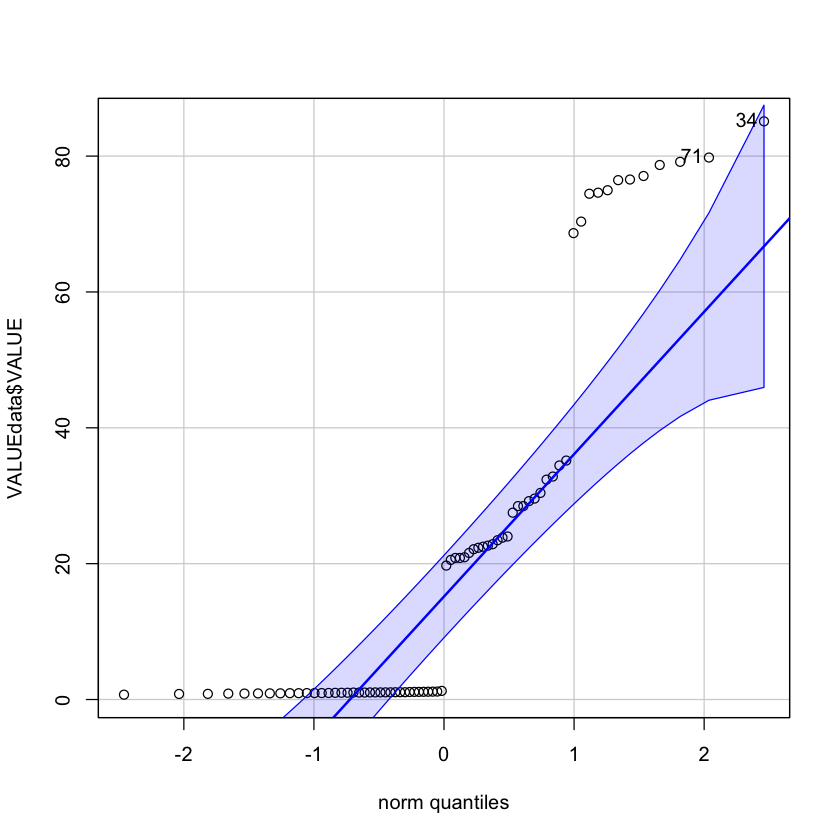

In [4]:
#VALUEdata=read.csv(choose.files())
VALUEdata <- tallcsv2
VALUEdata$VALUE <- as.numeric(as.character(VALUEdata$VALUE))
print(head(VALUEdata))
#Normal distribution
qqp(VALUEdata$VALUE, "norm")

Linear mixed model fit by maximum likelihood . t-tests use Satterthwaite's
  method [lmerModLmerTest]
Formula: VALUE ~ Treatment + (1 | Trial)
   Data: VALUEdata

     AIC      BIC   logLik deviance df.resid 
   388.1    410.8   -184.0    368.1       62 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-2.5304 -0.5176  0.0823  0.3476  3.2503 

Random effects:
 Groups   Name        Variance Std.Dev.
 Trial    (Intercept) 1.342    1.158   
 Residual             9.041    3.007   
Number of obs: 72, groups:  Trial, 4

Fixed effects:
                        Estimate Std. Error        df t value Pr(>|t|)    
(Intercept)             1.009739   1.043437 18.767292   0.968    0.345    
Treatment02 wt_2h      24.065732   1.227500 67.623973  19.605   <2e-16 ***
Treatment03 arm3a.1_0h  0.587593   1.542966 70.621184   0.381    0.704    
Treatment04 arm3a.1_2h 25.704027   1.542966 70.621184  16.659   <2e-16 ***
Treatment05 arm3a.2_0h -0.593997   1.542966 70.621184  -0.385    0.701    
Tre

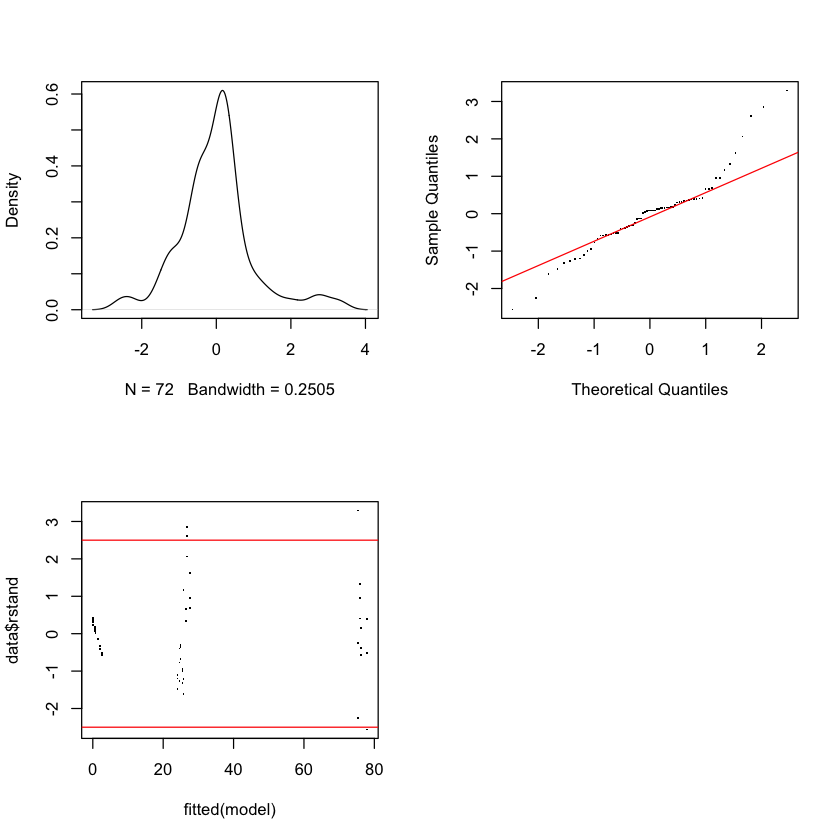

In [5]:
#set REML to FALSE if the data is normal, so we can use the maximum likelihood because the data are normal, we have similar sample sizes between effects, and we only have one random effect
VALUE.lmm<-lmer(VALUE ~ Treatment + (1|Trial), data = VALUEdata, REML = FALSE)
m<-lmer(VALUE ~ Treatment + (1|Trial), data = VALUEdata, REML = FALSE)
#the density plot should look roughly normal, centered on 0. In the quantile plot the black dots should roughly mirror the red line. And in the fitted residual plot most black dots should be between the red lines, with no obvious skew from left to right.
mcp.fnc(VALUE.lmm)
#If the above looks good, then we can get the model characteristics
summary(VALUE.lmm)
summary_name1 <- paste0("01.",dir_name, "_LMM_summary.txt")
capture.output(summary(VALUE.lmm), file = summary_name1)

In [6]:
#anova analysis of lmm
aov <- anova(m)
print(summary(aov))
# Save the summary to a text file
summary_name2 <- paste0("02.",dir_name, "_anova_summary.txt")
capture.output(summary(aov), file = summary_name2)

#Tukey's post-hoc, load library multcomp
tukey_result <- glht(m, linfct = mcp(Treatment = "Tukey"))
multcomps <- cld(tukey_result, alpha=0.1)
print(summary(tukey_result))
# Save the summary to a text file
summary_name3 <- paste0("03.",dir_name, "_multcomp_summary.txt")
capture.output(summary(tukey_result), file = summary_name3)

print(multcomps)
multcomp_name <- paste0("04.",dir_name, "_multcomp_letters.txt")
capture.output(print(multcomps), file = multcomp_name)

     Sum Sq         Mean Sq         NumDF       DenDF          F value     
 Min.   :51621   Min.   :7374   Min.   :7   Min.   :67.45   Min.   :815.7  
 1st Qu.:51621   1st Qu.:7374   1st Qu.:7   1st Qu.:67.45   1st Qu.:815.7  
 Median :51621   Median :7374   Median :7   Median :67.45   Median :815.7  
 Mean   :51621   Mean   :7374   Mean   :7   Mean   :67.45   Mean   :815.7  
 3rd Qu.:51621   3rd Qu.:7374   3rd Qu.:7   3rd Qu.:67.45   3rd Qu.:815.7  
 Max.   :51621   Max.   :7374   Max.   :7   Max.   :67.45   Max.   :815.7  
     Pr(>F)         
 Min.   :1.444e-62  
 1st Qu.:1.444e-62  
 Median :1.444e-62  
 Mean   :1.444e-62  
 3rd Qu.:1.444e-62  
 Max.   :1.444e-62  

	 Simultaneous Tests for General Linear Hypotheses

Multiple Comparisons of Means: Tukey Contrasts


Fit: lmer(formula = VALUE ~ Treatment + (1 | Trial), data = VALUEdata, 
    REML = FALSE)

Linear Hypotheses:
                                     Estimate Std. Error z value Pr(>|z|)    
02 wt_2h - 01 wt_0h == 0       